# Transmission Line Spectrum Modeling

In this notebook, we model a CPW transmission line capacitively coupled to a CPW readout resonator via Purcell filter.

[Scikit-rf](https://scikit-rf.readthedocs.io/en/latest/) provides a CPW media object that can be used as a building block for our chip network model, and estimate S-matrix elements (see [this](https://scikit-rf.readthedocs.io/en/latest/tutorials/Circuit.html)).


In [13]:
import skrf as rf
from skrf.media.cpw import CPW
rf.stylely()

In [14]:
# Building the circuit
Z_0 = 50
freq = rf.Frequency(start=6, stop=6.1, unit='GHz', npoints=3001)
port1 = rf.Circuit.Port(freq, 'port1', z0=Z_0) # Launcher 1
port2 = rf.Circuit.Port(freq, 'port2', z0=Z_0) # Launcher 2

# Circuit element generators
# CPW generator object
cpw = CPW(frequency = freq, w = 10e-6, s = 6e-6, ep_r = 11.9)
# Capacitor generator object
capacitor = rf.DefinedGammaZ0(freq, z0=50).capacitor

# Circuit element definitions
tl_1 = cpw.line(d = 100e-6, unit='deg', name='trans_line1') # Probeline trait connected to launcher 1
tl_2 = cpw.line(d = 100e-6, unit='deg', name='trans_line2') # Probeline trait connected to launcher 2
readout_res = cpw.line(d = 4.87e-3, unit = 'm', name='readout_res') # Readout resonator
purcell_filter = cpw.line(d = 4.0e-3, unit = 'm', name='purcell_filter') # Purcell filter
c_r = capacitor(0.122e-14, name='C_r') # Purcell filter - readout resonator capacitance
c_p = capacitor(15.222e-14, name='C_p') # Probeline - Purcell filter capacitance
gnd = rf.Circuit.Ground(freq, name='gnd') # Reference to ground

# Connections
# A connection list of nodes. Each node is itself a list of element connected to it.
# Each element connection to a specific node is defined by a tuple (element, 'port-id').
# 'port-id' can be either 0 or 1 for most lumped elements (except for n-port elements like tees)
# and it indicates which port is connected to the node.
cnx = [
    [(port1, 0), (tl_1, 0)],
    [(tl_1, 1), (c_p, 0), (tl_2, 0)],
    [(c_p, 1), (purcell_filter, 0), (c_r, 0)],
    [(tl_2, 1), (port2, 0)],
    [(purcell_filter, 1), (gnd,0)],
    [(c_r, 1),(readout_res, 0) ],
    [(readout_res, 1),(gnd, 1) ]
]
cir = rf.Circuit(cnx)

2-Port Network: '',  6.0-6.1 GHz, 3001 pts, z0=[50.+0.j 50.+0.j]


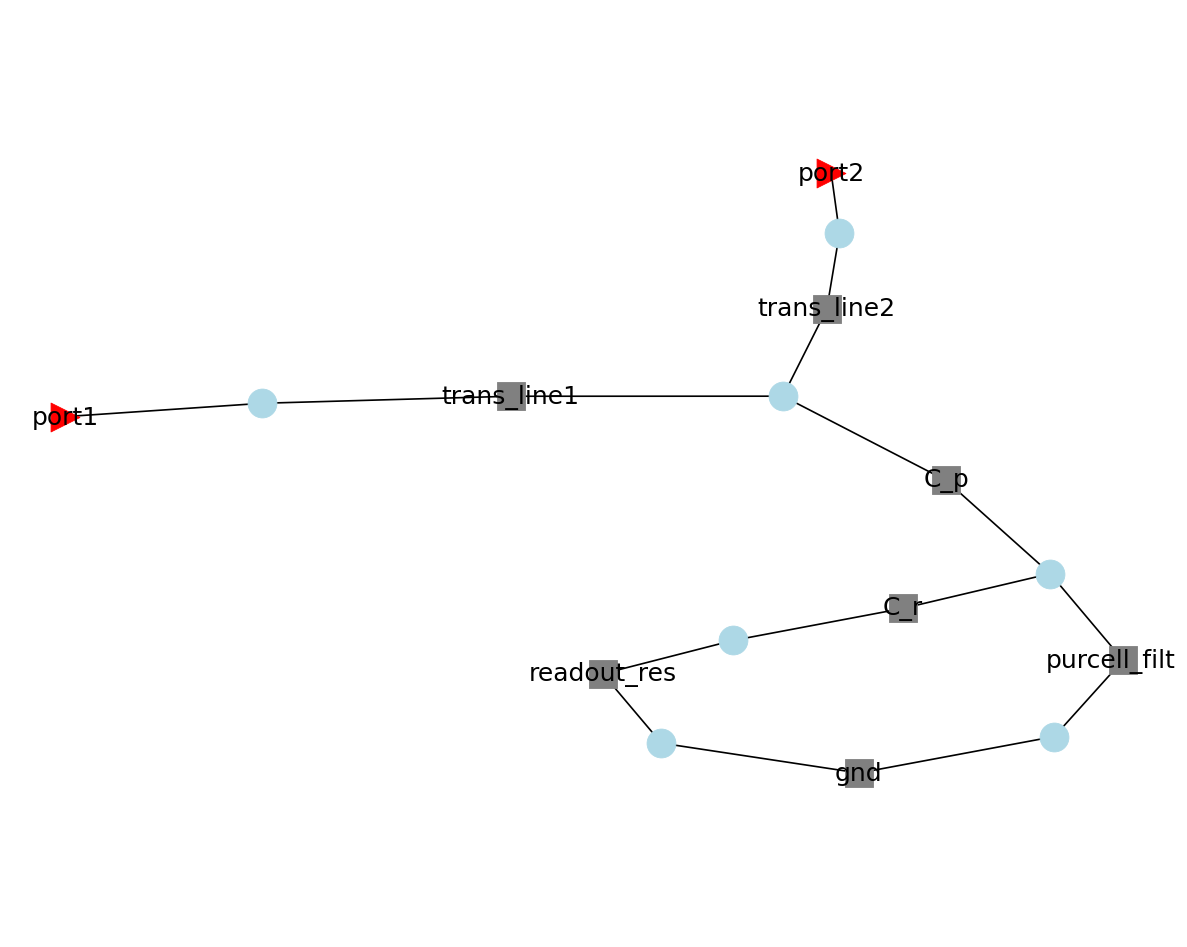

In [15]:
# Plot the network as a graph
cir.plot_graph(network_labels=True, network_fontsize=15,
               port_labels=True, port_fontsize=15,
               edge_fontsize=10)

# Get the resulting Network from the 'network' parameter:
ntw = cir.network
print(ntw)

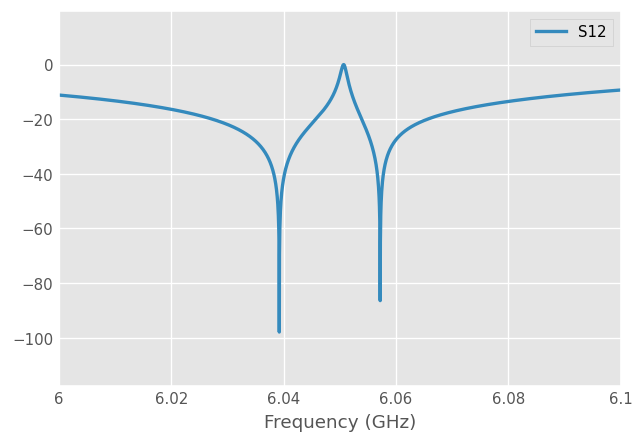

In [16]:
# Plot S12 through port1 and port2.
# Thanks to and avoided-crossing mechanism, the readout resonator points upwards and is 
# approximatively centered in the wider Purcell filter resonance.
ntw.plot_s_db(m=0, n=1, lw=2)